In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
import os
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url
# from utils.evaluation import find_landfalling_tcs,tc_region

In [3]:
precip_cmap,precip_norm = make_cmap()
levels = [10, 15, 20, 25, 30, 40, 50,75, 100]

In [4]:
# open storm dataset
tc_dir = '/user/home/al18709/work/event_sets/wgan_scalar/'
tc_dir = '/user/home/al18709/work/event_sets/wgan_modular/'
storm_filename = 'validation_mraw_2017253N14130.nc'
storm = xr.open_dataset(tc_dir + storm_filename)
storm_scores = np.load(tc_dir + 'validation_mraw_critic_2017253N14130.npy')

tc_dir_truth = '/user/home/al18709/work/event_sets/truth/'
storm_truth = xr.open_dataset(tc_dir_truth + 'validation_2017253N14130.nc')

tc_dir_wgan = '/user/home/al18709/work/event_sets/wgan/'
storm_wgan = xr.open_dataset(tc_dir_wgan + 'validation_2017253N14130.nc')

In [5]:
topography = xr.open_dataset('/user/home/al18709/work/topography/topography_10km_nn.nc')

In [6]:
print(topography)

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1800)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    z        (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  COARDS/CF-1.0
    history:      Fri Jan 06 13:22:57 2023: cdo remapnn,mygrid ETOPO1_Bed_g_g...
    title:        ETOPO1_Bed_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [7]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50,75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100

print(lats.shape)
print(lons.shape)


ntime,_,_,_ = storm.precipitation.shape
rain = storm.precipitation[0,:,:,0]
rain_truth = storm_truth.precipitation[0,:,:,0]


(100, 100)
(100, 100)


In [8]:
# find storm extent
fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(139, 275)
(139, 275)


In [9]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain_truth = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))
grid_rain_wgan = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	
	storm_rain_truth = storm_truth.precipitation[t,:,:,0]
	storm_rain_wgan = storm_wgan.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	for i in range(20):
		storm_rain = storm.precipitation[t,:,:,i]
		grid_rain[t,sel[1],sel[0],i] = storm_rain
		grid_rain_wgan[t,sel[1],sel[0],i] = storm_rain_wgan
	grid_rain_truth[t,sel[1],sel[0]] = storm_rain_truth
	

In [10]:
total_storm_rain = np.sum(grid_rain[:,:,:,0],axis=0)
total_storm_rain_truth = np.sum(grid_rain_truth,axis=0)
rain_bool = total_storm_rain > 50
print(np.sum(rain_bool))
rain_grid_x = grid_x[rain_bool]

rain_bool_truth = total_storm_rain_truth > 50
print(np.sum(rain_bool_truth))
rain_grid_x_truth = grid_x[rain_bool_truth]

7026
7180


In [11]:
hit = (rain_bool == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss = (rain_bool == False) & (rain_bool_truth == True)
hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
print('Hit rate: ',hit_rate*100)

false_alarm = (rain_bool == True) & (rain_bool_truth == False)
correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
print('false alarm rate',false_alarm_rate*100)

# equitable threat score is:
# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
# http://cimss.ssec.wisc.edu/goes/comet/threat.html
# ETS = (hits - E) / (hits + misses + false alarms - E)
# E = (number of forecast points * number of observed points) / total number of points possible

n_forecast_points = np.sum(rain_bool == True)
n_observed_points = np.sum(rain_bool_truth == True)
total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points*n_observed_points) / total_points_possible
ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
print('ETS: ', ETS)

# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.

6567
Hit rate:  91.46239554317549
false alarm rate 1.4784989531325496
ETS:  0.8303601518326568


In [12]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	# print('max rain',np.max(rain['precipitation'].values))
	print('max rain',np.max(rain))
	# population = population.where(rain['precipitation'].values > threshold,0)
	population = population.where(rain > threshold,0)
	# exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	pop = population.population.values
	pop[pop == -inf] = 0
	exposure = np.nansum(pop)
	return exposure

In [13]:
accumulated_rain = np.sum(grid_rain,axis=0)


In [14]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
pop = population_count * 144


pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_273757/2558955332.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144


In [15]:
# plt.imshow(data)
print(np.min(data))
data[data == -inf] = 0

-inf


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


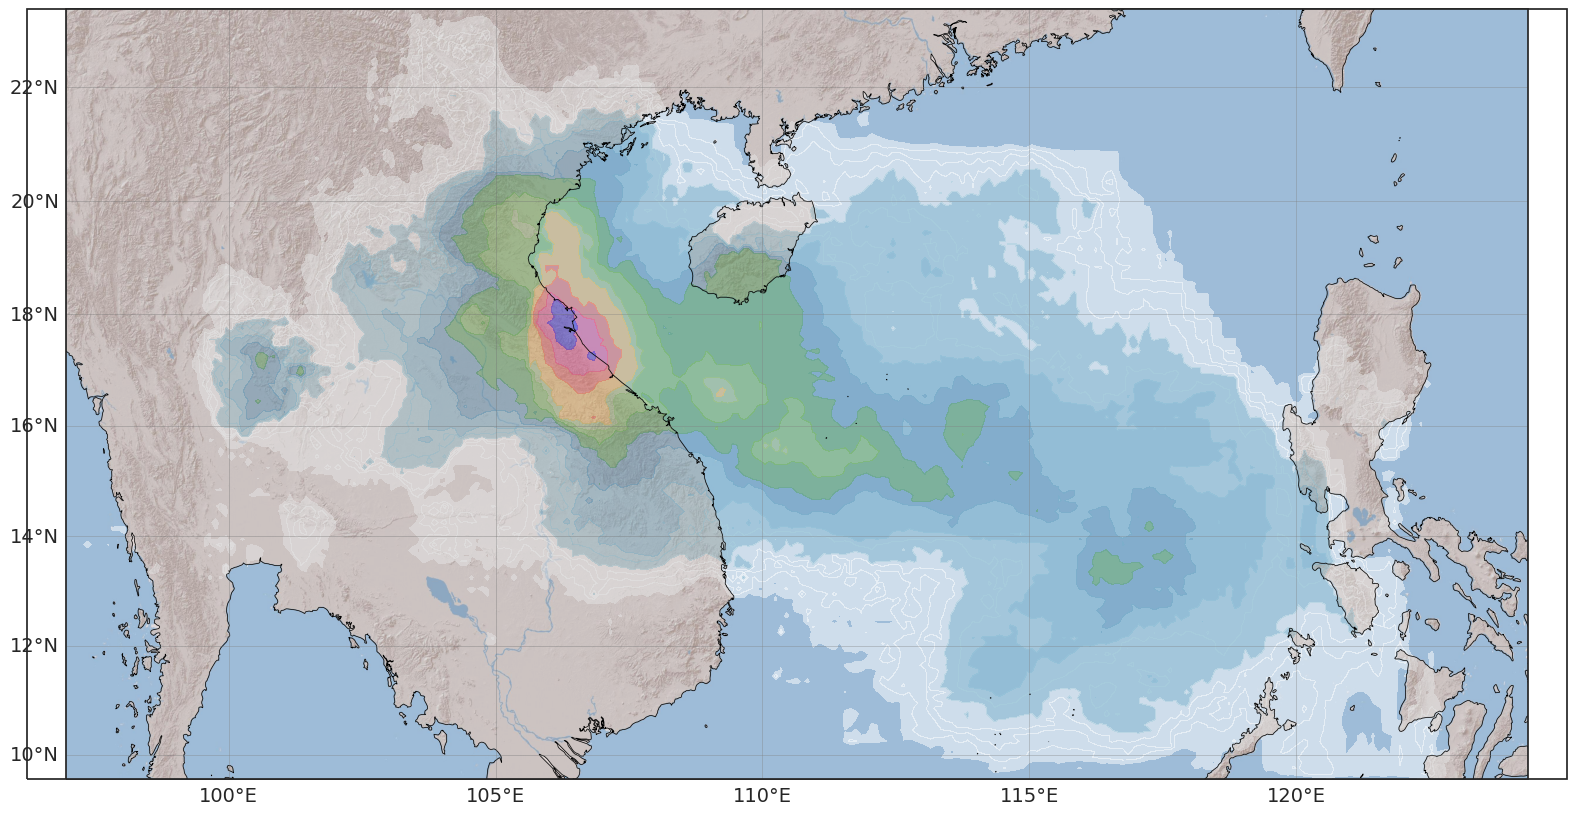

In [16]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300,350,400,450]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=450


fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

# ax.contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
# ax.contourf(lon,lat,topography.z.values, transform=ccrs.PlateCarree(),alpha=0.8)


# ax.contourf(grid_x,grid_y,np.sum(grid_rain,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
ax = plt.axes(projection=ShadedReliefESRI().crs)
ax.add_image(ShadedReliefESRI(), 8)

ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
ax.contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.5)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
# ax.set_title('title',fontsize=26,pad=15)

plt.savefig('figure_10a_rain.png',bbox_inches='tight')

In [17]:
print(grid_x)
print(grid_y)

[[ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 ...
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]
 [ 96.95      97.05      97.15001  ... 124.15001  124.250015 124.35002 ]]
[[ 9.549998  9.549998  9.549998 ...  9.549998  9.549998  9.549998]
 [ 9.649997  9.649997  9.649997 ...  9.649997  9.649997  9.649997]
 [ 9.749995  9.749995  9.749995 ...  9.749995  9.749995  9.749995]
 ...
 [23.149998 23.149998 23.149998 ... 23.149998 23.149998 23.149998]
 [23.249996 23.249996 23.249996 ... 23.249996 23.249996 23.249996]
 [23.350002 23.350002 23.350002 ... 23.350002 23.350002 23.350002]]


In [18]:
# exposure
# storm_pop = pop.sel(lat=slice(-lats[-1]+1+12,-lats[0]+12), lon=slice(lons[0],lons[-1]+1))
# print(storm_pop)
# storm_pop_data = storm_pop.population.values
# print(storm_pop_data.shape)
# print(np.sum(grid_rain,axis=0).shape)
# print(grid_x.shape)
print(pop.population.shape)
accumulated_rain = np.sum(grid_rain[:,:,:,0],axis=0)
accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)


# superimpose rain onto bigger grid
global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

storm_lons = grid_x
storm_lats = grid_y
storm_rain = accumulated_rain
storm_rain_truth = accumulated_rain_truth

Mlon = storm_lons[-1,-1]
mlon = storm_lons[0,0]
Mlat = storm_lats[-1,-1]
mlat = storm_lats[0,0]
grid_X,grid_Y = np.meshgrid(lon,lat)
Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

# Create a selection
sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

global_rain[sel[1],sel[0]] = storm_rain
global_rain_truth[sel[1],sel[0]] = storm_rain_truth



pred_exposure = exposure_calc(pop,global_rain,150)
truth_exposure = exposure_calc(pop,global_rain_truth,150)


(1800, 3600)
max rain 471.995989486786
max rain 390.9375044682027


In [19]:
def ets(total_storm_rain,total_storm_rain_truth,pop):

	rain_bool = total_storm_rain > 50
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > 50
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	print('Hit rate: ',hit_rate*100)
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	print('false alarm rate',false_alarm_rate*100)
	pop_false_alarm = np.sum(pop[false_alarm])
	pop_correct_rejection = np.sum(pop[correct_rejection])
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection)

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	print(ETS_pop)

	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [20]:
print(pop)

global_pop = pop.population.values

global_pop[global_pop == -inf] = 0

print(global_pop.shape)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -inf -inf -inf -inf ... -inf -inf -inf -inf
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
(1800, 3600)


In [21]:
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(global_rain,global_rain_truth,global_pop)

Hit rate:  91.46239554317549
false alarm rate 0.007091190547551145
ETS:  0.859524335587636
0.92693144


In [22]:
print(pop_hit_rate * 100)
print(pop_false_alarm_rate * 100)
print(grid_rain.shape)
print(grid_rain_truth.shape)


97.49850034713745
0.07417466258630157
(28, 139, 275, 20)
(28, 139, 275)


In [23]:
n_time_steps,n,m,_ = grid_rain.shape
combo_rain = np.zeros((n_time_steps,n,m))
print(storm_scores.shape)
for t in range(n_time_steps):
	t_scores = storm_scores[t,:]
	best_score = np.argmax(t_scores)
	combo_rain[t,:,:] = grid_rain[t,:,:,best_score]

ensemble_combo = np.sum(combo_rain,axis=0)
print(t_scores)
print(ensemble_combo.shape)

(28, 1, 20)
[[47.54525757 48.75710297 48.02509689 47.73864746 47.93764114 47.6751709
  47.78130722 47.34612656 47.35216141 46.71697235 46.40663528 47.6869545
  48.37958145 48.20969009 47.85663605 48.21191025 48.05379868 48.06455231
  47.94090652 47.5953331 ]]
(139, 275)


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


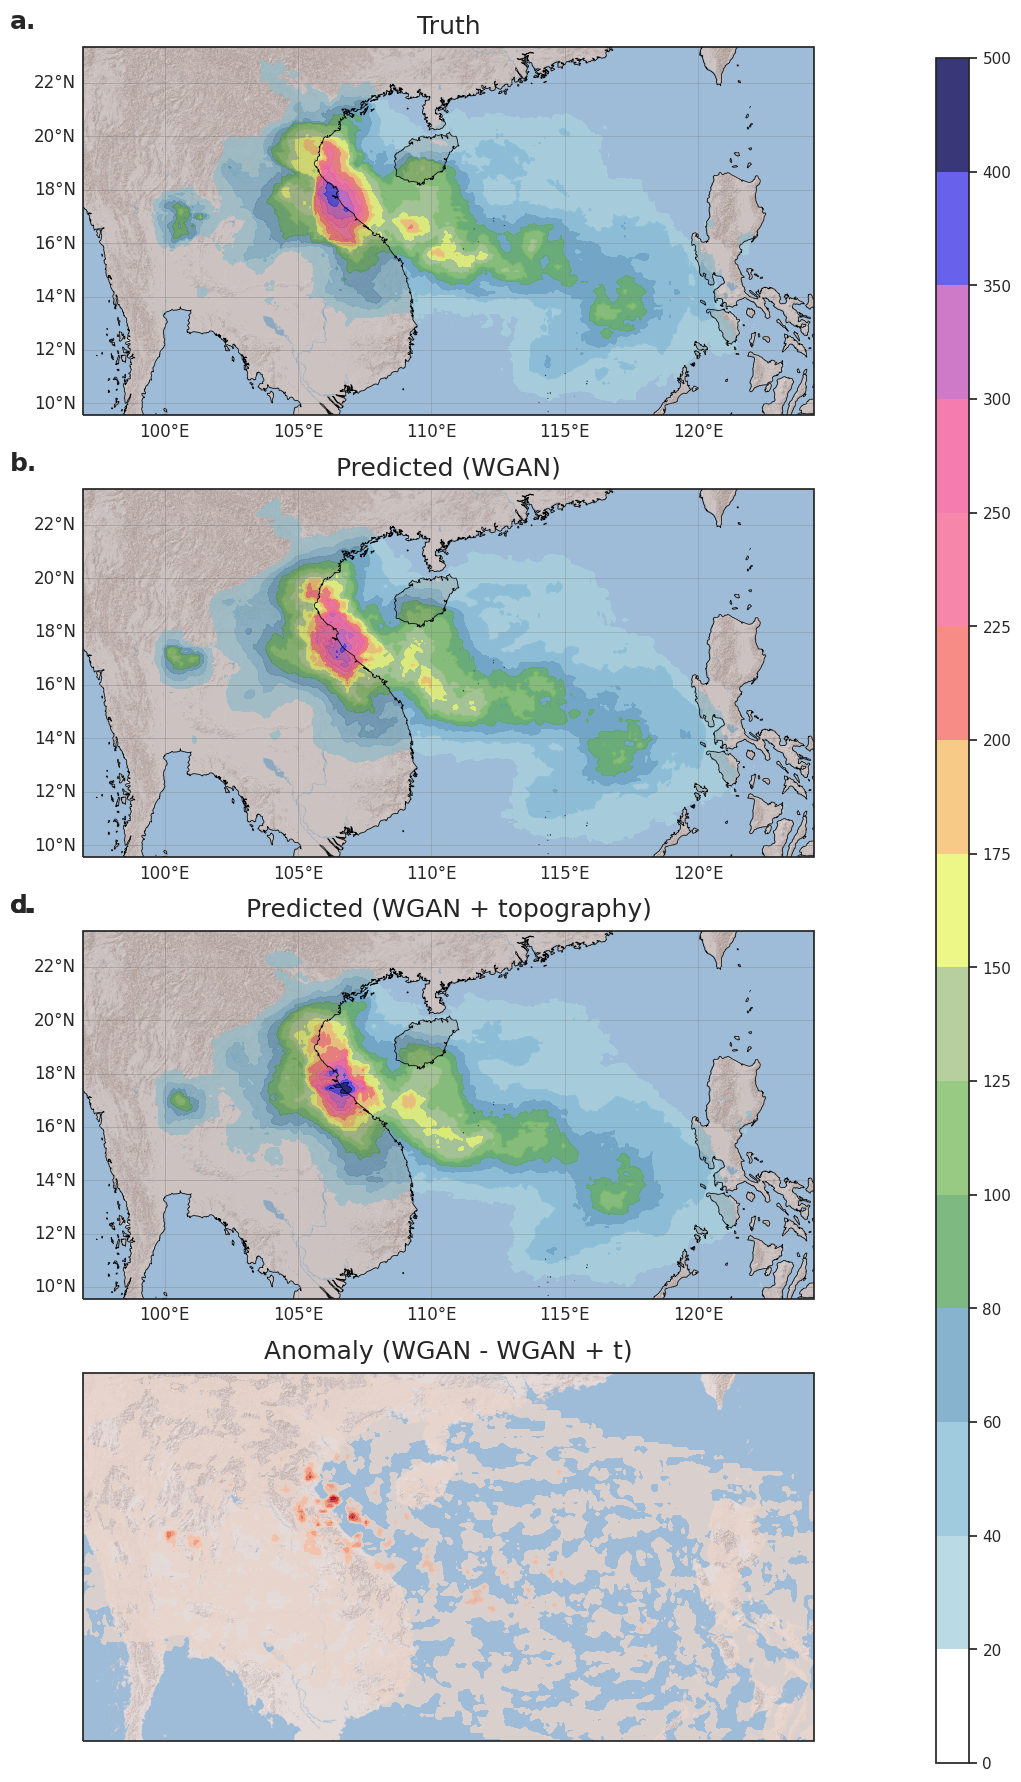

In [30]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=450


fig, axes = plt.subplots(4,1,figsize=(10,22),subplot_kw={'projection': ccrs.PlateCarree()})
rain1 = np.sum(grid_rain[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
m = axes[0].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, norm=precip_norm, transform=ccrs.PlateCarree(),alpha=0.8)
# axes[0] = plt.axes(projection=ShadedReliefESRI().crs)
axes[0].add_image(ShadedReliefESRI(), 8)
m.collections[0].set_alpha(0)
# second panel

agreement_range = 20
ensemble_max = np.max(np.sum(grid_rain[:,:,:,:],axis=0),axis=-1)
agree_mask = np.all([np.abs(np.sum(grid_rain[:,:,:,0],axis=0) - ensemble_max) <= agreement_range,
                    np.abs(np.sum(grid_rain[:,:,:,1],axis=0) - ensemble_max) <= agreement_range,
                    np.abs(np.sum(grid_rain[:,:,:,2],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,3],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,4],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,5],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,6],axis=0) - ensemble_max) <= agreement_range],
					axis=0)
print(agree_mask)
agree_mask = np.all([agree_mask,ensemble_max > 10],axis=0)
contour = axes[1].contourf(grid_x,grid_y,np.sum(grid_rain_wgan[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm, transform=ccrs.PlateCarree(),alpha=0.8)
contour.collections[0].set_alpha(0)
# axes[1] = plt.axes(projection=ShadedReliefESRI().crs)
axes[1].add_image(ShadedReliefESRI(), 8)


contour2 = axes[2].contourf(grid_x,grid_y,np.sum(grid_rain[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm,  transform=ccrs.PlateCarree(),alpha=0.8)
# axes[2] = plt.axes(projection=ShadedReliefESRI().crs)
contour2.collections[0].set_alpha(0)
axes[2].add_image(ShadedReliefESRI(), 8)

contour3 = axes[3].contourf(grid_x,grid_y,np.sum(grid_rain_wgan[:,:,:,0],axis=0) - np.sum(grid_rain[:,:,:,0],axis=0),vmin=-100,vmax=100,levels=levels,cmap = 'coolwarm',  transform=ccrs.PlateCarree(),alpha=0.8)
# axes[2] = plt.axes(projection=ShadedReliefESRI().crs)
# contour3.collections[0].set_alpha(0)
axes[3].add_image(ShadedReliefESRI(), 8)

for i in range(3):
	axes[i].add_feature(cfeature.COASTLINE,linewidth=0.5)
	axes[i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


	# ax.outline_patch.set_linewidth(0.5)
	gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
	gl.xlabels_top = False
	gl.ylabels_right = False
	gl.xlabel_style = {'size': 12}
	gl.ylabel_style = {'size': 12}
	# ax.set_xticklabels(labelsize=20)
	# ax.set_yticklabels(labelsize=20)
	axes[i].tick_params(axis='x', labelsize=14)
	axes[i].tick_params(axis='y', labelsize=14)

# precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
	axes[i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
# ax.set_title('Hit and Miss',fontsize=18,pad=15)

axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=18, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=18, weight='bold')
axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=18, weight='bold')
axes[3].text(-0.1, 1.05, 'd.', transform=axes[2].transAxes, size=18, weight='bold')
# axes[4].text(-0.1, 1.05, 'd.', transform=axes[4].transAxes, size=18, weight='bold')
# axes[5].text(-0.1, 1.05, 'e.', transform=axes[5].transAxes, size=18, weight='bold')
# legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
# axes[2].legend(handles=legend_handles, loc='upper right')

axes[0].set_title('Truth',fontsize=18,pad=10)
axes[1].set_title('Predicted (WGAN)',fontsize=18,pad=10)
axes[2].set_title('Predicted (WGAN + topography)',fontsize=18,pad=10)
axes[3].set_title('Anomaly (WGAN - WGAN + t)',fontsize=18,pad=10)
# axes[3].set_title('Predicted (ensemble max)',fontsize=18,pad=10)
# axes[4].set_title('Standard deviation',fontsize=18,pad=10)
# axes[5].set_title('Hit and Miss',fontsize=18,pad=10)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

cbar_ax = fig.add_axes([1, 0.1, 0.033, 0.775])
cb = fig.colorbar(m, cax=cbar_ax,shrink=0.01,ticks=levels)
plt.savefig('figure_10b_topography.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most porbable rainfall (not mean) up to 95th percentile


In [25]:
# TODO 
# the question is, what level of extreme rainfall can we be confident in calculating the exposure to?
# how often are we wrong when it's 50mm,100mm,150mm
# how often are we right?
# do the ensemble combining method with critic score so best of 20 images are selected


In [31]:
# Analysis

# global stats, NH/SH split, basin split

# RMSE mountains vs flat

# ETS score (ETS_50mm ETS_100mm etc) mountains vs flat 

# CSI ?


# number of storms which track over mountains globally, NH, SH
# population exposure of mountain TC rainfall



In [34]:
print(storm_wgan.precipitation.shape)

(28, 100, 100, 20)


In [51]:
def globalise_storm_rain(storm,prediction=True):

	# define initial variables
	ntime,_,_,_ = storm.precipitation.shape

	# define global extent
	fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	grid_x, grid_y = np.meshgrid(lon,lat)

	# superimpose rain onto global grid
	if prediction == True:
		grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
	else:
		grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

	for t in range(ntime):
		storm_lons = storm.storm_lons[t,:,:]
		storm_lats = storm.storm_lats[t,:,:]

		Mlon = storm_lons[-1,-1]
		mlon = storm_lons[0,0]
		Mlat = storm_lats[-1,-1]
		mlat = storm_lats[0,0]
		if mlon.values > Mlon.values:
			continue
		Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
		Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

		# Create a selection
		sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

		if prediction == True:
			for i in range(20):
				storm_rain = storm.precipitation[t,:,:,i]
				grid_rain[t,sel[1],sel[0],i] = storm_rain
		else:
			storm_rain = storm.precipitation[t,:,:]
			grid_rain[t,sel[1],sel[0]] = storm_rain
	return grid_rain



In [52]:
tc_dir = '/user/home/al18709/work/event_sets/wgan_modular/'
storm_filename = 'validation_mraw_\*.nc'
tc_files = os.listdir(tc_dir)
global_rain = np.zeros((1,1800,3600,20))
for storm_filename in tc_files:
	if ('validation_mraw' in storm_filename) & ('.nc' in storm_filename):
		print(storm_filename)
		storm = xr.open_dataset(tc_dir + storm_filename)
		storm_rain = globalise_storm_rain(storm)
		global_rain = global_rain + np.sum(storm_rain,axis=0)

validation_mraw_2003269N12322.nc
-49.34999465942383 -39.45000076293945 16.450000762939453 26.349998474121094
-49.549991607666016 -39.64999771118164 16.950000762939453 26.849998474121094
-49.45000076293945 -39.549991607666016 17.549999237060547 27.450000762939453
-49.34999465942383 -39.45000076293945 17.950000762939453 27.849998474121094
-49.049991607666016 -39.14999771118164 18.450000762939453 28.349998474121094
-48.64999771118164 -38.750003814697266 18.85000228881836 28.75
-48.14999771118164 -38.250003814697266 19.35000228881836 29.25
-47.64999771118164 -37.750003814697266 19.749996185302734 29.650001525878906
-46.95000076293945 -37.049991607666016 20.450000762939453 30.349998474121094
-45.64999771118164 -35.750003814697266 21.64999771118164 31.549999237060547
-44.049991607666016 -34.14999771118164 22.749996185302734 32.650001525878906
-43.250003814697266 -33.34999465942383 23.249996185302734 33.150001525878906
-42.45000076293945 -32.549991607666016 23.749996185302734 33.6500015258789

KeyboardInterrupt: 

In [53]:
np.save('/user/home/al18709/work/event_sets/wgan_modular/validation_mraw_global.npy',global_rain)


# tc = globalise_storm_rain(storm)

In [54]:
print(global_rain.shape)

(1, 1800, 3600, 20)


In [40]:
print(tc.shape)

(28, 1800, 3600, 20)


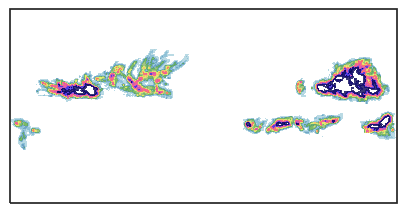

In [57]:
fig, axes = plt.subplots(1,1,figsize=(5,10),subplot_kw={'projection': ccrs.PlateCarree()})
axes.contourf(lon,lat,global_rain[0,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm,  transform=ccrs.PlateCarree(),alpha=0.8)
plt.show()

In [71]:
topography_mask = topography.z <= 1000
print(topography_bool.shape)
mountain_rain = global_rain
mountain_rain[0,topography_mask,:] = 0
# print(mountain_rain.shape)
print(mountain_rain.shape)

(1800, 3600)
(1, 1800, 3600, 20)


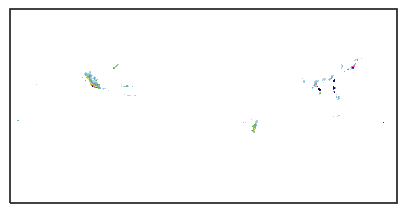

In [72]:
fig, axes = plt.subplots(1,1,figsize=(5,10),subplot_kw={'projection': ccrs.PlateCarree()})
axes.contourf(lon,lat,mountain_rain[0,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap,norm=precip_norm,  transform=ccrs.PlateCarree(),alpha=0.8)
plt.show()